Creating training data bathes
Creating validation data batches
Epoch 1/50
92/92 [==============================] - 491s 5s/step - loss: 1.7877 - accuracy: 0.1960 - val_loss: 1.7453 - val_accuracy: 0.2716
Epoch 2/50
92/92 [==============================] - 6s 65ms/step - loss: 1.7455 - accuracy: 0.2430 - val_loss: 1.7135 - val_accuracy: 0.2346
Epoch 3/50
92/92 [==============================] - 6s 69ms/step - loss: 1.6651 - accuracy: 0.2945 - val_loss: 1.6191 - val_accuracy: 0.2922
Epoch 4/50
92/92 [==============================] - 6s 68ms/step - loss: 1.5712 - accuracy: 0.3567 - val_loss: 1.4797 - val_accuracy: 0.4636
Epoch 5/50
92/92 [==============================] - 7s 81ms/step - loss: 1.4161 - accuracy: 0.4555 - val_loss: 1.4059 - val_accuracy: 0.4554
Epoch 6/50
92/92 [==============================] - 6s 63ms/step - loss: 1.2931 - accuracy: 0.5108 - val_loss: 1.4315 - val_accuracy: 0.4691
Epoch 7/50
92/92 [==============================] - 8s 82ms/step - loss: 1.2003 - accuracy:

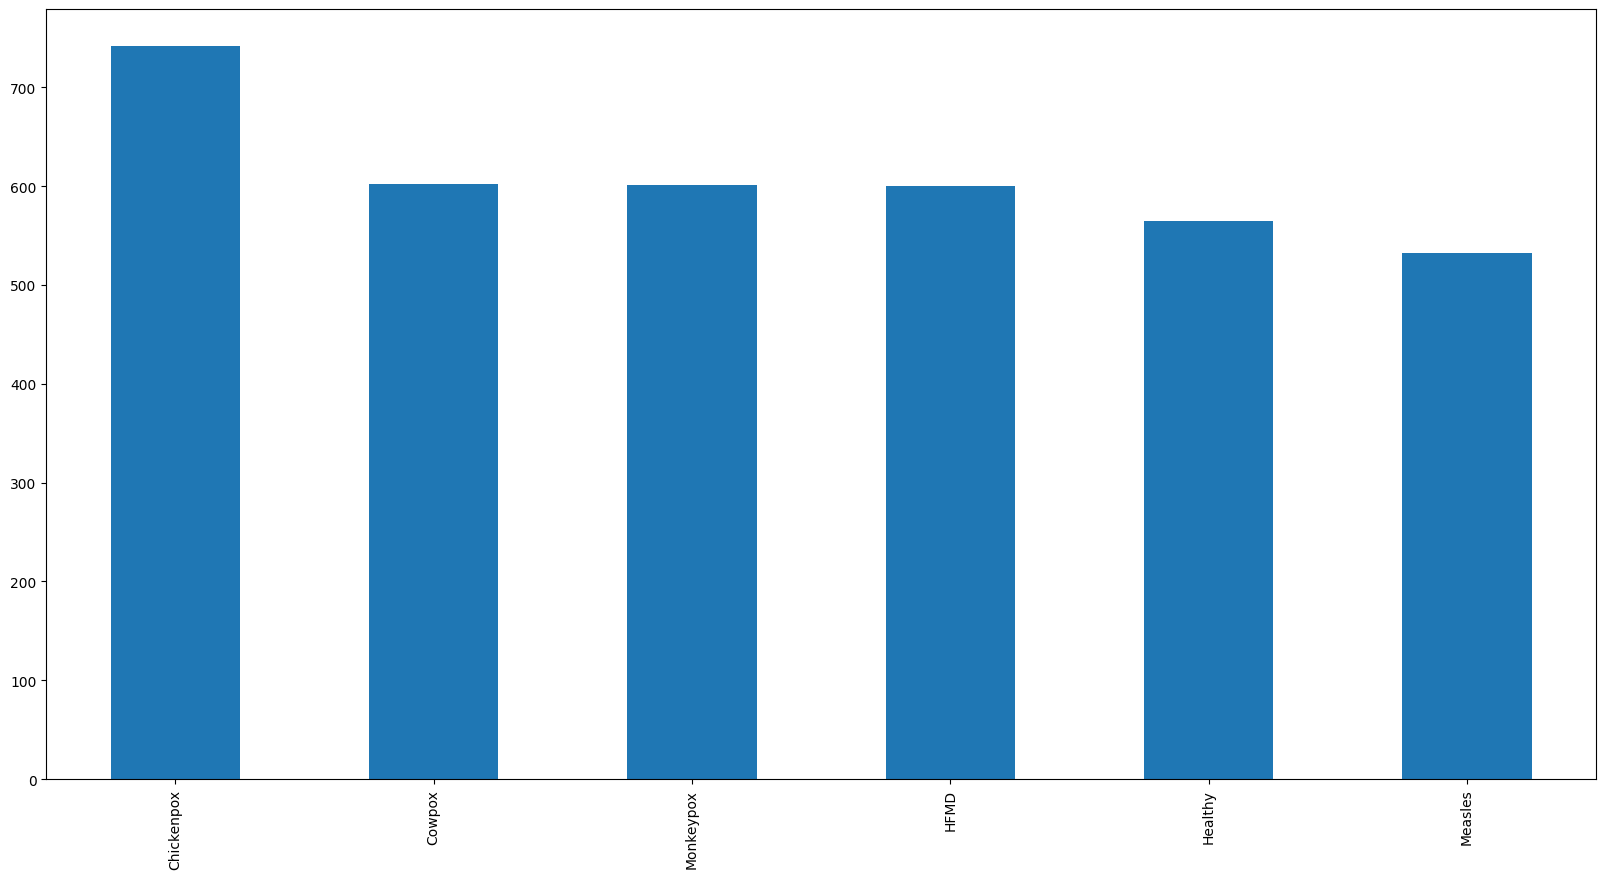

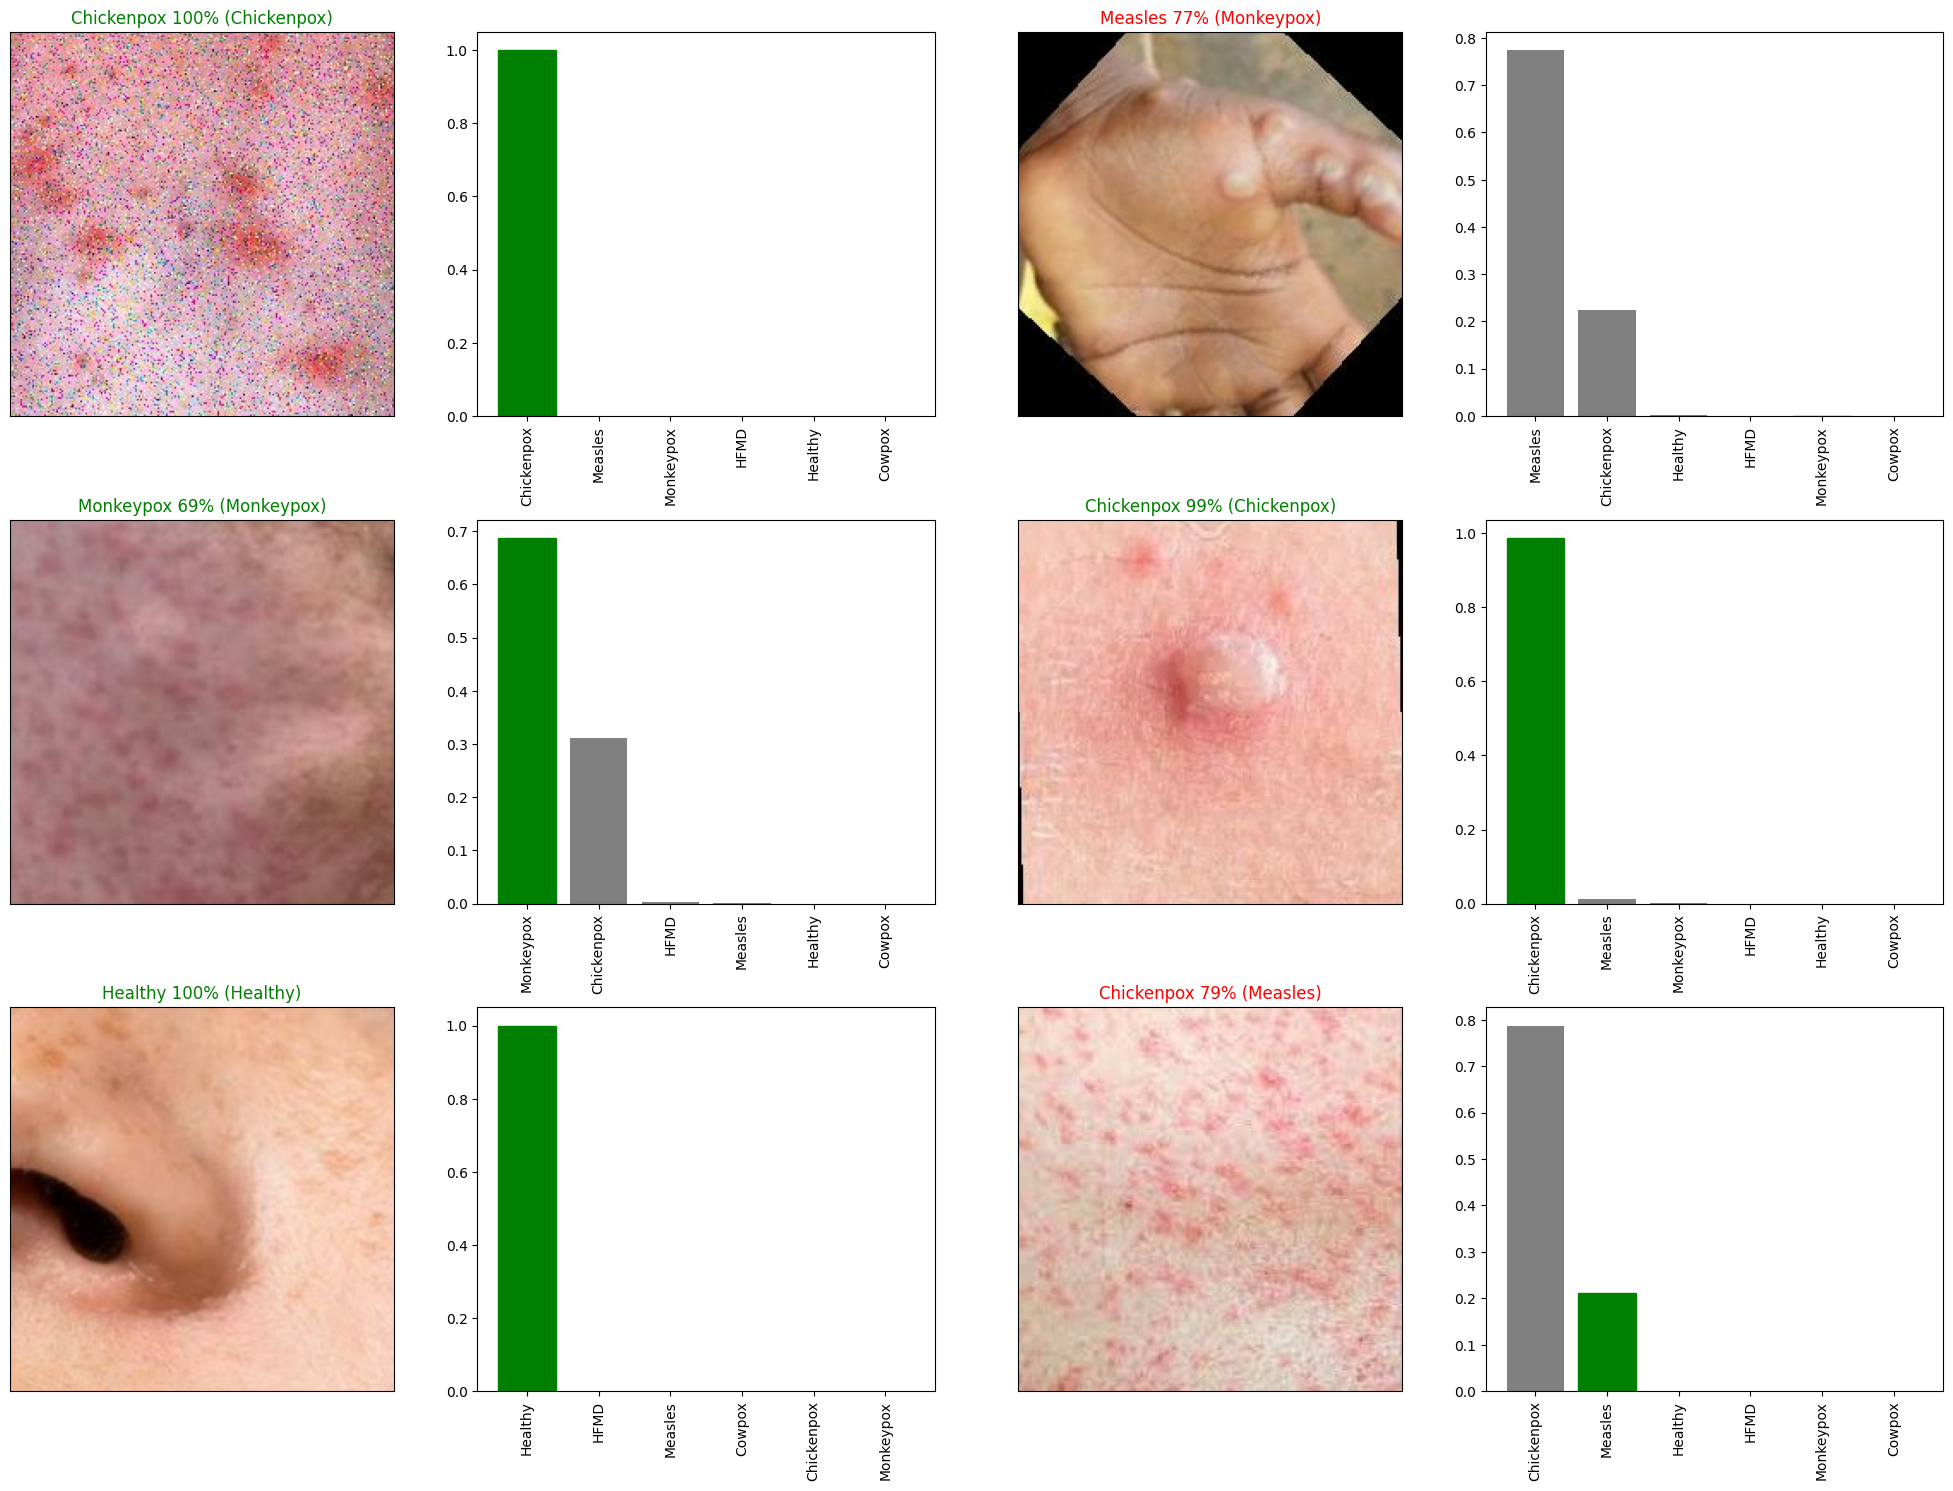

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

labels_csv = pd.read_csv('drive/MyDrive/Skin-disease-detector/labels.csv')
# print(labels_csv.describe())
# print(labels_csv.head())
# labels_csv["disease"].value_counts().plot.bar(figsize=(20,10))
# plt.show()

from IPython.display import display, Image

augmented_df = pd.read_csv("drive/MyDrive/Skin-disease-detector/labels_augmented.csv")
augmented_df["disease"].value_counts().plot.bar(figsize=(20,10))
# plt.show()
filenames = ["drive/MyDrive/Skin-disease-detector/Augmented Images/Train/" + fname + ".jpg" for fname in augmented_df["id"]]
# print(filenames[:10])

labels = augmented_df["disease"].to_numpy()
unique_disease = np.unique(labels)

boolean_labels = [label == np.array(unique_disease) for label in labels]

####

####
X = filenames
y = boolean_labels

NUM_IMAGES = len(augmented_df)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

# print(X_train[:5])
# print(y_train[:2])

# Convert image to numpy array
image = plt.imread(filenames[42])
# print(image.shape)

IMG_SIZE = 224


def process_image(image_path):
    # Read
    image = tf.io.read_file(image_path)
    # 3 Channels Color, turn in to numberical Tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image


def get_image_label(image_path, label):
    image = process_image(image_path)
    return image, label


BATCH_SIZE = 32


# Turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        print("Creating test data batches")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    elif valid_data:
        print("Creating validation data batches")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else:
        print("Creating training data bathes")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data = data.shuffle(buffer_size=len(x))
        data = data.map(get_image_label)
        data_batch = data.batch(BATCH_SIZE)
    return data_batch


train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)


# Show 25 images
def show_25_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(unique_disease[labels[i].argmax()])
        plt.axis("off")


train_images, train_labels = next(train_data.as_numpy_iterator())
# show_25_images(train_images, train_labels)
# plt.show()

##### BUILDING MODEL !!!!!!
# Set up input shape w batch, height, width and color
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(unique_disease)


# Using CNN Architecture
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output and add dense layers
    model.add(Flatten())
    model.add(Dense(units=OUTPUT_SHAPE, activation='relu'))
    model.add(Dense(units=OUTPUT_SHAPE, activation='softmax'))

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    model.build(INPUT_SHAPE)
    return model


# model = create_model()
# model.summary()
epochs = 50


def train_model():
    model = create_model()
    model.fit(x=train_data,
              epochs=epochs,
              validation_data=val_data,
              validation_freq=1,  # check validation metrics every epoch
              )
    return model


model = train_model()
predictions = model.predict(val_data, verbose=1)


### Test Model with File Test in Dataset
def get_pred_label(prediction_probabilities):
  return unique_disease[np.argmax(prediction_probabilities)]


def unbatchify(data):
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_disease[np.argmax(label)])
  return images, labels

val_images, val_labels = unbatchify(val_data)
def plot_pred(prediction_probabilities, labels, images, n=1):
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
    pred_label = get_pred_label(pred_prob)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"
    plt.title("{} {:2.0f}% ({})".format(pred_label,
                                        np.max(pred_prob) * 100,
                                        true_label),
                                        color=color)

# plot_pred(prediction_probabilities=predictions,
#           labels=val_labels,
#           images=val_images)
# plt.show()

def plot_pred_conf(prediction_probabilities, labels, n=1):
      pred_prob, true_label = prediction_probabilities[n], labels[n]
      pred_label = get_pred_label(pred_prob)
      top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
      top_10_pred_values = pred_prob[top_10_pred_indexes]
      top_10_pred_labels = unique_disease[top_10_pred_indexes]
      top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                         top_10_pred_values,
                         color="grey")
      plt.xticks(np.arange(len(top_10_pred_labels)),
                 labels=top_10_pred_labels,
                 rotation="vertical")
      if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
      else:
        pass

# plot_pred_conf(prediction_probabilities=predictions,
#                labels=val_labels,
#                n=9)
# plt.show()''

i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [10]:
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)
predmodel = model.predict(val_data, len(val_data))
y_pred = model.predict(X_val)
y_predicr= np.argmax(y_pred, axis = 1)

classlabel = ['Chikenpox','Cowpox','HFMD','Heathy','Measles','Monkeypox']
print(classification_report(np.argmax(y_val,axis = 1),y_predicr))

23/23 [==============================] - 1s 45ms/step


ValueError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')